# Importing modules # 

In [ ]:
!pip3 install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 19.5 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=459bffeef218715e7668fab64bf54e568aa68e7cf0b00408a1e0009f9c7a40f9
  Stored in directory: /root/.cache/pip/wheels/dc/25/8b/072b221a5cff4f04e7999d39ca1b6cb5dad702cc3e1da951d4
Successfully built pyclustering


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import silhouette_score
import re
from matplotlib.pyplot import figure
from sklearn import metrics


from pandas.io.formats.style_render import DataFrame
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES


# Connect to Drive # 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/Shareddrives/DM_Project/dataset/users_clustering.csv /content/
# !cp /content/drive/Shareddrives/DM_Project/dataset/users.csv /content/

# Utility functions

In [ ]:
def get_labels(clusters, X):
  labels = [x for x in range(X.shape[0])]
  for c in range(len(clusters)):
    for point in clusters[c]:
      labels[point] = c

  labels = np.array(labels)
  return labels

def get_sse(labels, centers, X, K):
  sum = 0
  for k in range(K):
    datas = X[labels == k]
    center = centers[k]
    for data in datas:
      dist = np.linalg.norm(data - center)**2
      sum += dist
  return sum

# Load dataset # 

In [ ]:
users = pd.read_csv("users_clustering.csv")

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11508 non-null  int64  
 1   name                    11508 non-null  object 
 2   lang                    11508 non-null  object 
 3   bot                     11508 non-null  int64  
 4   created_at              11508 non-null  object 
 5   statuses_count          11508 non-null  int64  
 6   reply_count_total       11508 non-null  float64
 7   favorite_count_total    11508 non-null  int64  
 8   num_hashtags_total      11508 non-null  int64  
 9   retweet_count_avg       11508 non-null  float64
 10  reply_count_avg         11508 non-null  float64
 11  favorite_count_avg      11508 non-null  float64
 12  num_hashtags_avg        11508 non-null  float64
 13  num_urls_avg            11508 non-null  float64
 14  num_mentions_avg        11508 non-null

In [ ]:
selected = users.columns.tolist()[5:]
data = users[selected]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   statuses_count          11508 non-null  int64  
 1   reply_count_total       11508 non-null  float64
 2   favorite_count_total    11508 non-null  int64  
 3   num_hashtags_total      11508 non-null  int64  
 4   retweet_count_avg       11508 non-null  float64
 5   reply_count_avg         11508 non-null  float64
 6   favorite_count_avg      11508 non-null  float64
 7   num_hashtags_avg        11508 non-null  float64
 8   num_urls_avg            11508 non-null  float64
 9   num_mentions_avg        11508 non-null  float64
 10  retweet_count_std       11508 non-null  float64
 11  reply_count_std         11508 non-null  float64
 12  favorite_count_std      11508 non-null  float64
 13  num_hashtags_std        11508 non-null  float64
 14  num_urls_std            11508 non-null

# Log tranformation of the data
We transform in logarithmic scale the attributes whose distribution is skewed

statuses_count


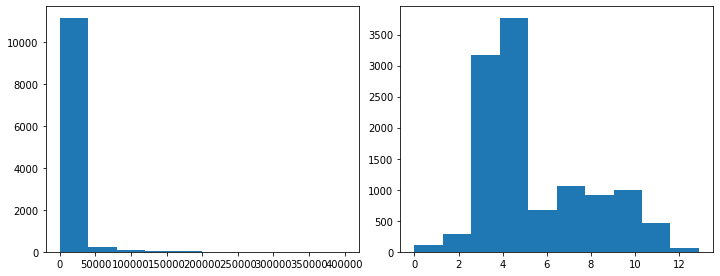

reply_count_total


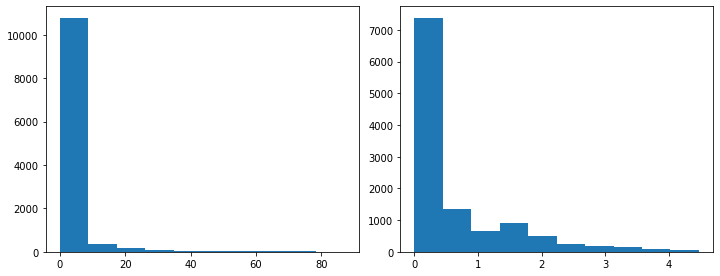

favorite_count_total


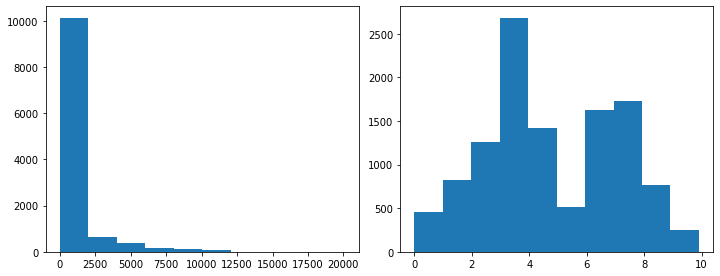

num_hashtags_total


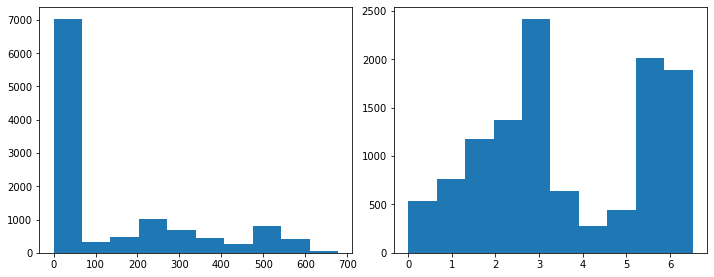

retweet_count_avg


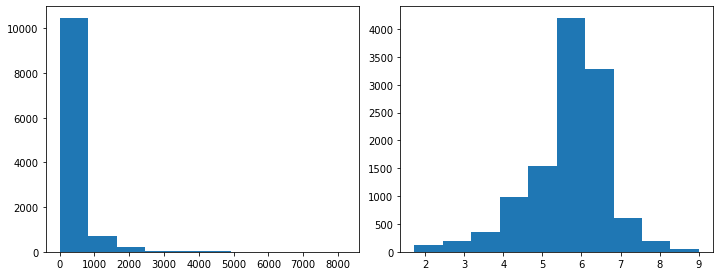

reply_count_avg


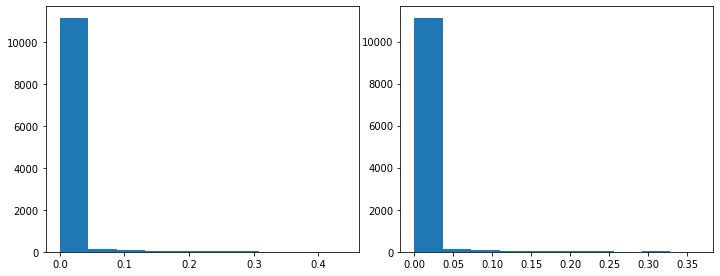

favorite_count_avg


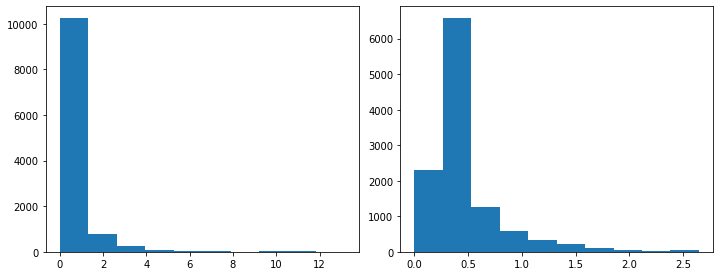

num_hashtags_avg


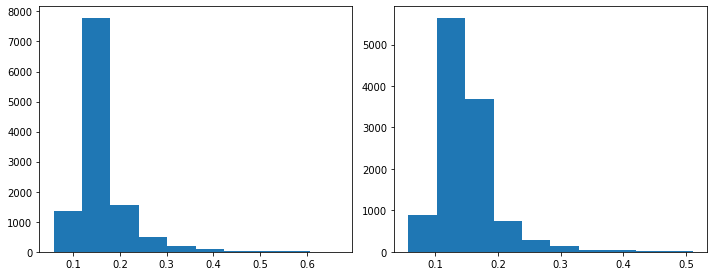

num_urls_avg


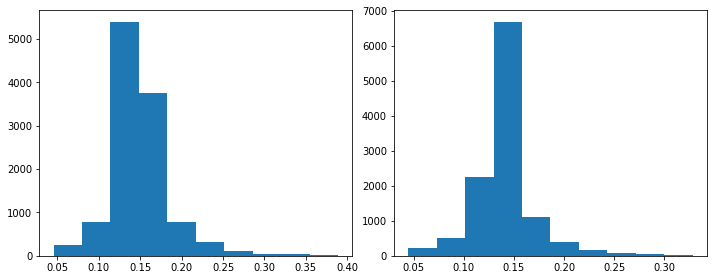

num_mentions_avg


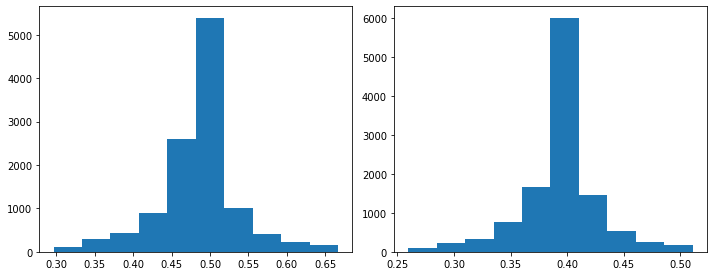

retweet_count_std


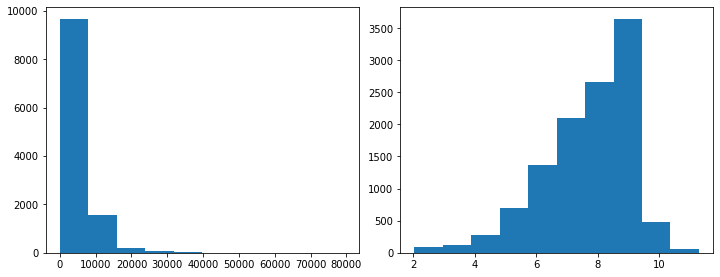

reply_count_std


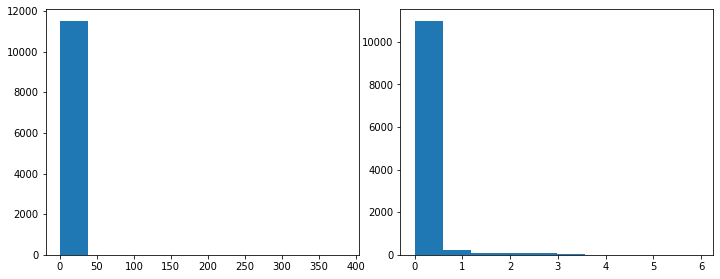

favorite_count_std


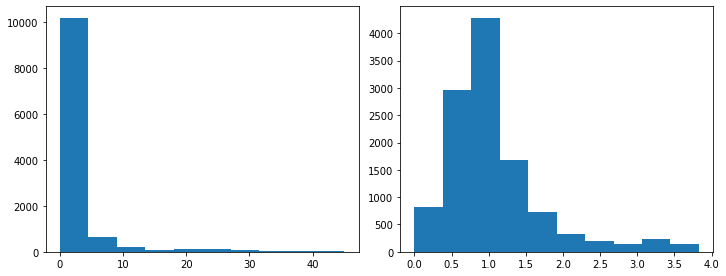

num_hashtags_std


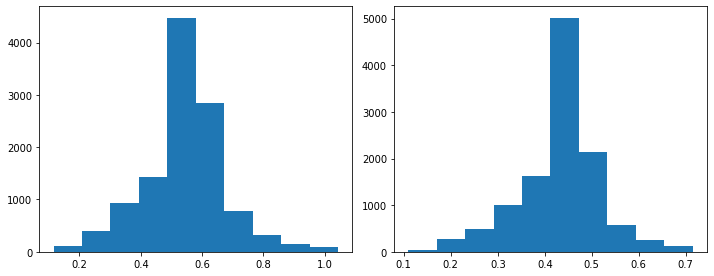

num_urls_std


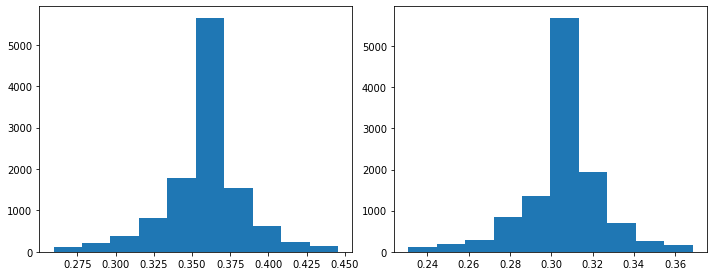

num_mentions_std


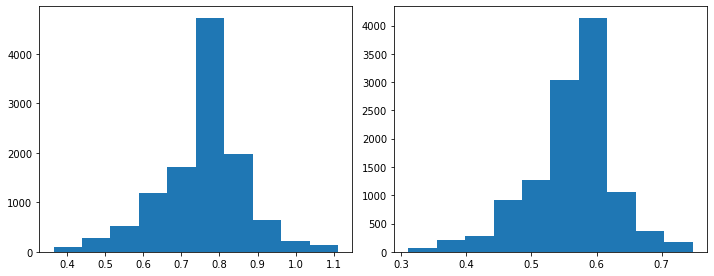

retweet_count_entropy


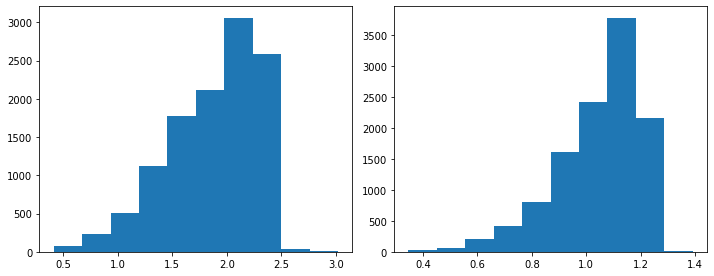

reply_count_entropy


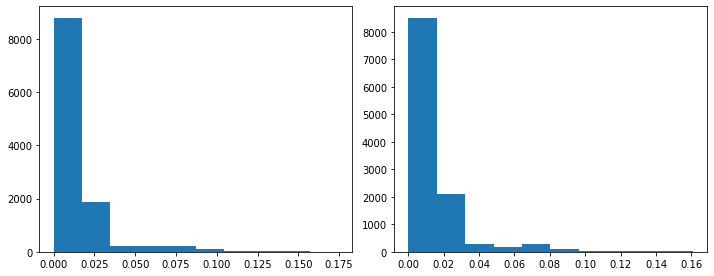

favorite_count_entropy


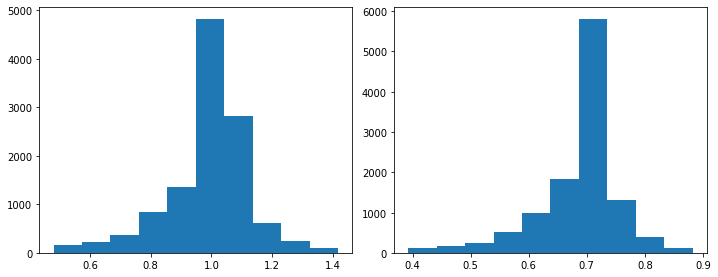

num_hashtags_entropy


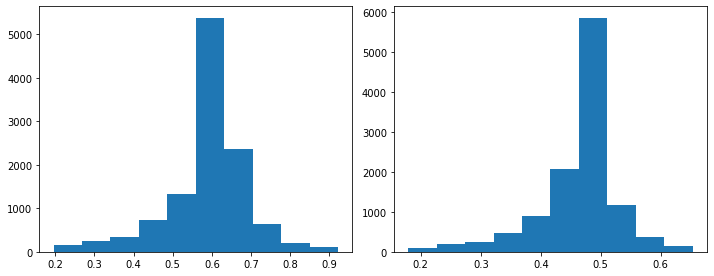

num_mentions_entropy


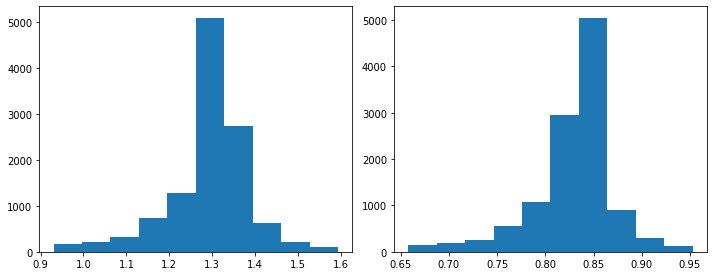

retweet_count_per_day


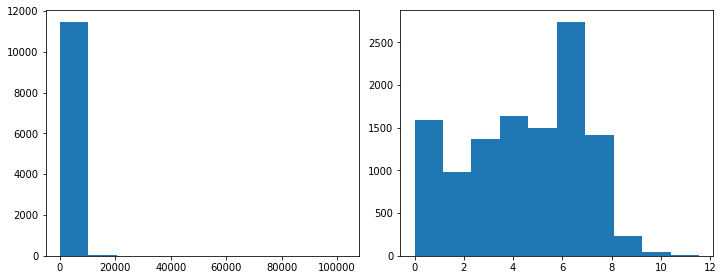

reply_count_per_day


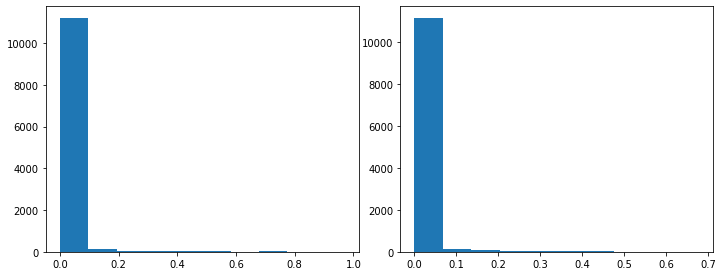

favorite_count_per_day


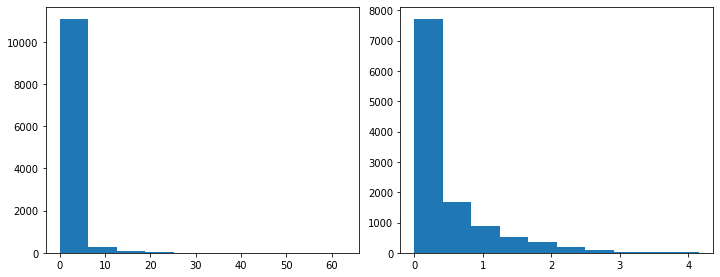

num_hashtags_per_day


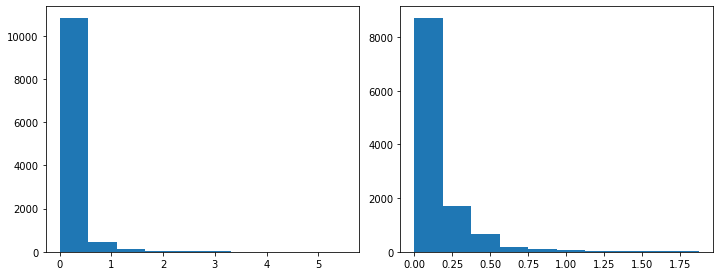

avg_len


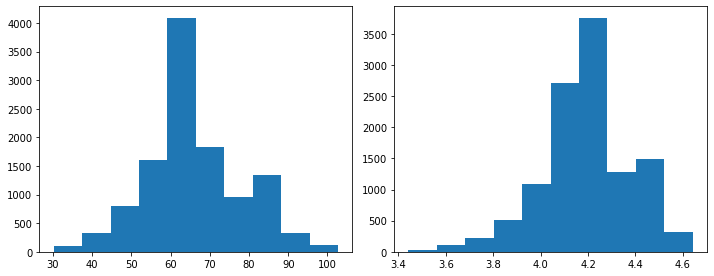

avg_spc_len


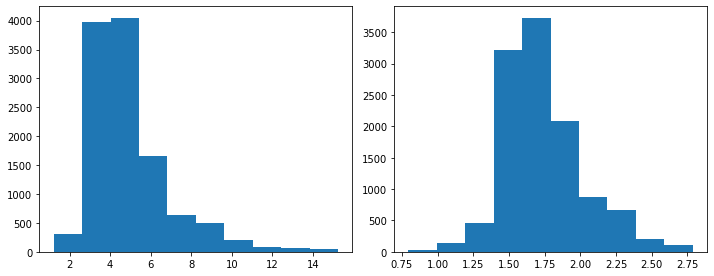

In [ ]:
for col in selected:
  print(col)
  vals = users[col]
  log_vals = users[col].apply(lambda x: np.log(x+1))
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(vals, bins=10)
  ax[1].hist(log_vals, bins=10)
  plt.show()

In [ ]:
non_skewed_dists = [
  "avg_spc_len",
  "avg_len",
  "num_mentions_entropy",
  "num_hashtags_entropy",
  "favorite_count_entropy",
  "retweet_count_entropy",
  "num_mentions_std",
  "num_urls_std",
  "num_hashtags_std",
  "num_mentions_avg",
  "num_urls_avg"
]

In [ ]:
for col in selected:
  if col not in non_skewed_dists:
    print(col)
    data.loc[:, col] = data[col].apply(lambda x: np.log10(x+1))

statuses_count
reply_count_total
favorite_count_total
num_hashtags_total
retweet_count_avg
reply_count_avg


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


favorite_count_avg
num_hashtags_avg
retweet_count_std
reply_count_std
favorite_count_std
reply_count_entropy
retweet_count_per_day
reply_count_per_day
favorite_count_per_day
num_hashtags_per_day


# Normalizing the data #

In [ ]:
method = "standard"

if method == "minmax":
  scaler = MinMaxScaler()
elif method == "standard":
  scaler = StandardScaler()

X = scaler.fit_transform(data.values)

# Test X-means #

In [ ]:
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X, amount_initial_centers).initialize()

xmeans_instance = xmeans(X, kmax=500, tolerance=0.1)
xmeans_instance.process()

clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
centers = np.array(centers)
labels = get_labels(clusters, X)


n_clusters = len(clusters)
print(n_clusters)

77


# Visualize with PCA #

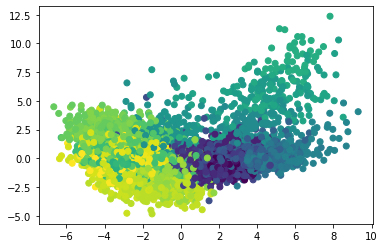

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)
X_pca.shape

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

# Count the number of users in each cluster

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76]
[114 111 118 154 161  75  35  74 204 313 117 268 161 117  99 134 113 127
  67 252 283 202 128  88  61 185 115 120  60  99  58  67 133  54  57  21
  62  43  28 130 170  51  24  24  30  17  23  48 253 201 214 117 141 304
 206 246 292 257 175 171 199 177 167 202 268 361 193 274 156 254 141 131
 347 140 368 175 183]


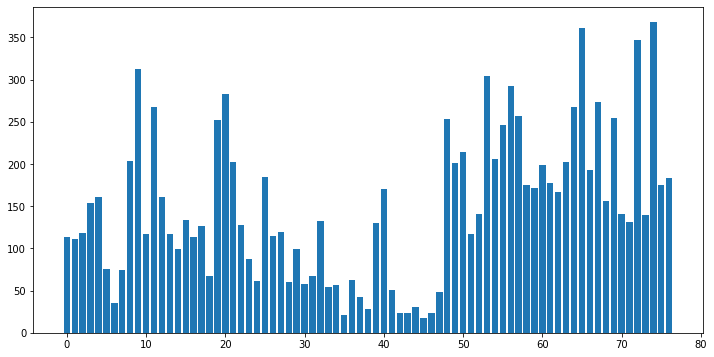

In [ ]:
val, count = np.unique(labels, return_counts=True)
print(val)
print(count)

plt.figure(figsize=(12, 6))
plt.bar(val, count)
plt.show()

In [ ]:
print('SSE %s' % get_sse(labels, centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))

SSE 102724.27029134033
Silhouette 0.06901800432004795
Separation 1.8878825427358217


# Visualize the centers

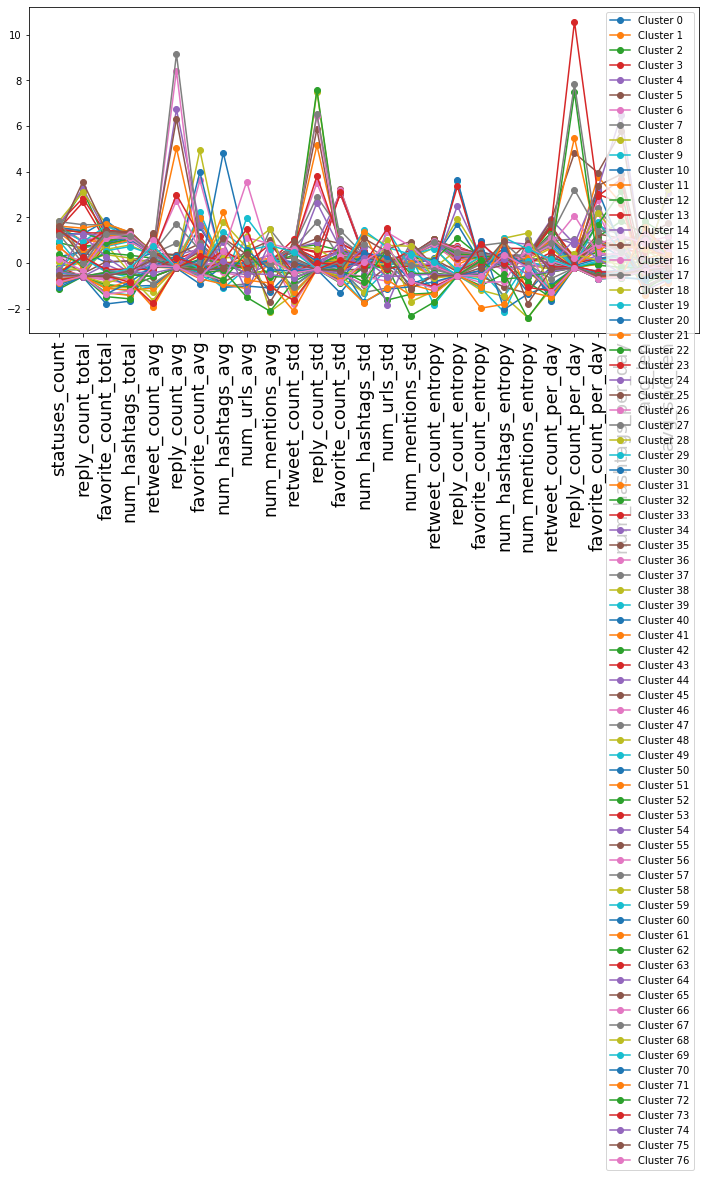

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(0, len(centers)):
  plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(data.columns)), data.columns, fontsize=18, rotation=90)
plt.legend(fontsize=10)
plt.show()

<ipython-input-18-0cdf2515db9f>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(polar=True)


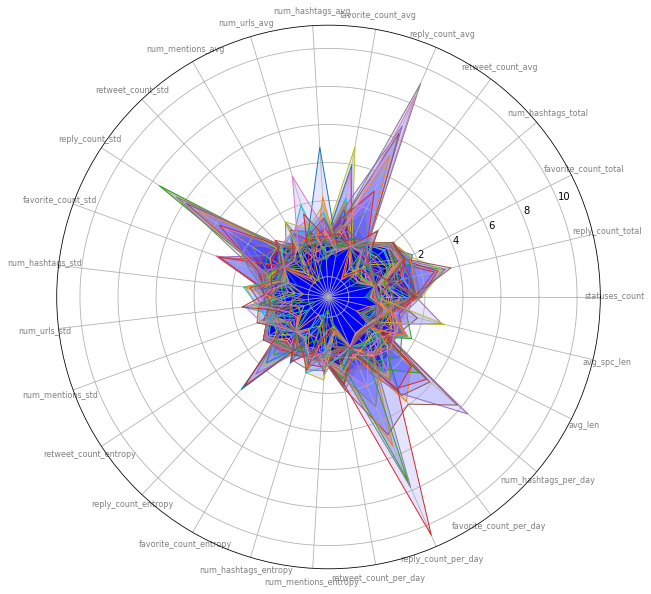

In [ ]:
from math import pi
 
# number of variable
N = len(data.columns)
fig = plt.figure(figsize=(10, 10))
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(centers)):
  angles = [n / float(N) * 2 * pi for n in range(N)]
  values = centers[i].tolist()
  values += values[:1]
  angles += angles[:1]
# Initialise the spider plot
  ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], data.columns, color='grey', size=8) 
# Plot data
  ax.plot(angles, values, linewidth=1, linestyle='solid')
# Fill area
  ax.fill(angles, values, 'b', alpha=0.1)


# Count bot and real users in each cluster

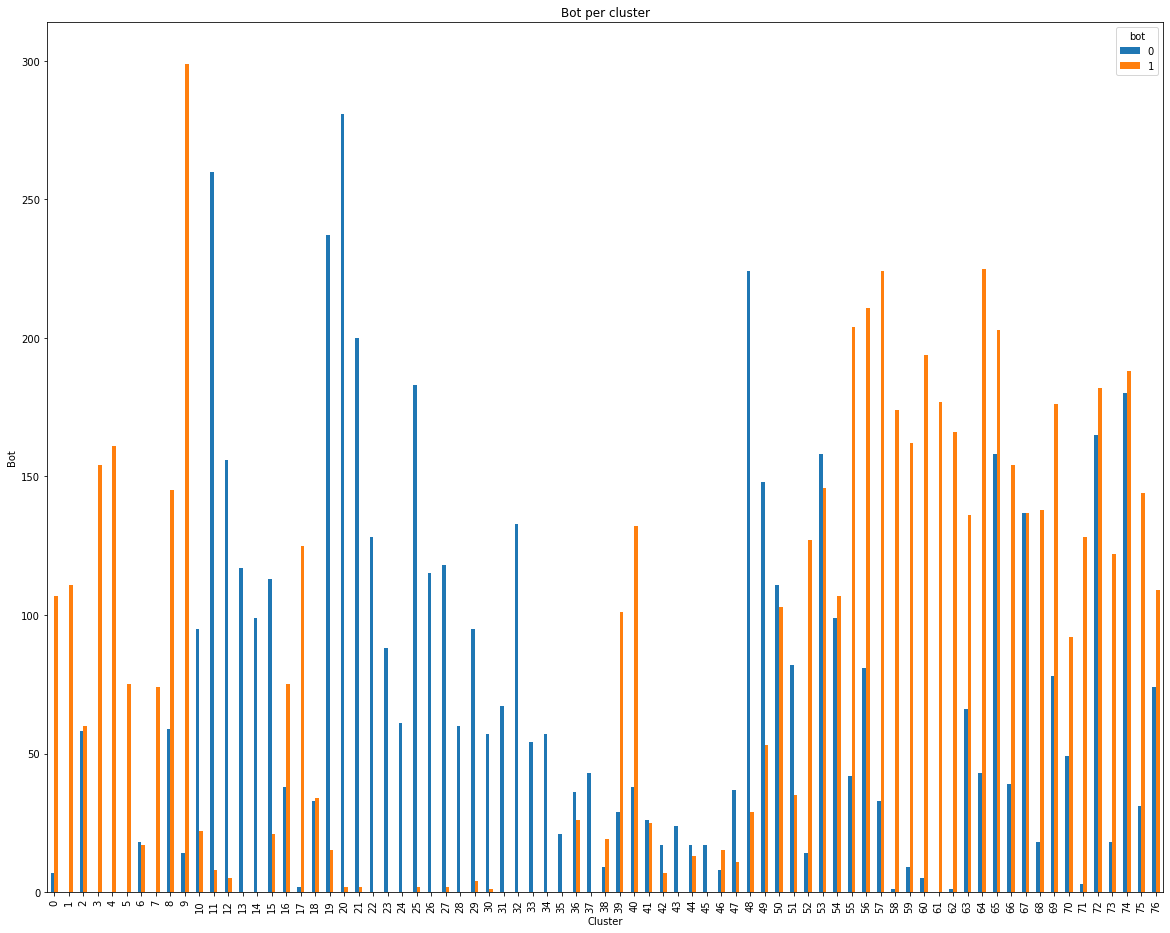

In [ ]:
bot_xt_pct = pd.crosstab(labels, users['bot'])
bot_xt_pct.plot(kind='bar', stacked=False, title='Bot per cluster', figsize=(20, 16))
plt.xlabel('Cluster')
plt.ylabel('Bot')
plt.show()